# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [49]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [50]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [51]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [52]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [53]:
((len(df[df['converted']==1]))/df.shape[0])*100

11.96591935560551

e. The number of times the `new_page` and `treatment` don't match.

In [54]:
df.query("group == 'treatment' & landing_page != 'new_page'").count()

user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

f. Do any of the rows have missing values?

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. We will separate out into 2 dataframes.

In [56]:
df2 = df.drop(df.query("group == 'treatment' & landing_page != 'new_page'").index, axis=0)
df2 = df2.drop(df.query("group == 'control' & landing_page != 'old_page'").index, axis=0)

In [57]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [58]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [59]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [60]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [61]:
df2.drop_duplicates('user_id', inplace = True)
df2.shape[0]

290584

a. What is the probability of an individual converting regardless of the page they receive?

In [62]:
(df2.query("converted == 1").converted.count()/df2.converted.count())*100

11.959708724499627

b. Given that an individual was in the `control` group, what is the probability they converted?

In [63]:
control_convert = (df2.query("group == 'control' & converted == 1").converted.count()/df2.query("group == 'control'").converted.count())*100
control_convert

12.03863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [64]:
treatment_convert = (df2.query("group == 'treatment' & converted == 1").converted.count()/df2.query("group == 'treatment'").converted.count())*100
treatment_convert

11.880806551510565

d. What is the probability that an individual received the new page?

In [65]:
(df2.query("landing_page == 'new_page'").converted.count()/df2.converted.count())*100

50.00619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

I do not believe there is sufficient evidence to make the conclusion that the new page leads to more conversions. The results from above show that the discrepancy between the two is very minimal.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$**: **$p_{new}$** - **$p_{old}$** <= 0

**$H_{1}$**: **$p_{new}$** - **$p_{old}$** > 0

<br>

The null hypothesis **$H_{0}$** is testing whether the conversion rates of the new page minus the conversion rates of the old page is less than or equal to zero. 

Alternatively, **$H_{1}$** is testing whether the conversion rates of the new page minus the conversion rates of the old page is greater than zero.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [66]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [67]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [68]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [69]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [70]:
new_page_converted = np.random.choice([0,1], n_new, p = [p_new, 1 - p_new])
new_page_converted

array([1, 1, 1, ..., 1, 0, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [71]:
old_page_converted = np.random.choice([0,1], n_old, p = [p_old, 1 - p_old])
old_page_converted

array([1, 1, 1, ..., 0, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [72]:
difference = new_page_converted.mean() - old_page_converted.mean()
difference

2.2633032691676824e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [73]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, p = [p_new, 1 - p_new], replace = True).mean()
    old_page_converted = np.random.choice([0,1], n_old, p = [p_old, 1 - p_old], replace = True).mean()
    p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

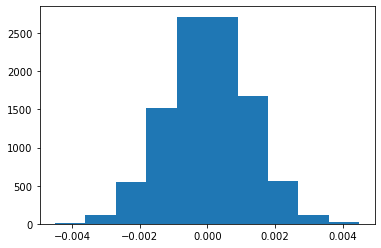

In [74]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [75]:
orig_diff = df2.query("group == 'treatment'")['converted'].mean() - df2.query("group == 'control'")['converted'].mean()
orig_diff

-0.0015782389853555567

In [76]:
(np.array(p_diffs) > orig_diff).mean()

0.9043

k. What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

In part j, we are computing the probability value or **p-value**. The **p-value** is based on if the null hypothesis is true and would reveal the likelihood that our data would have occurred in a random setting. Here our **p-value** is 0.90 and thus we would have to fail to reject the null hypothesis. The reason being is our **p-value** is higher than 0.05 which shows statistical insignificance and would favor the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [77]:
import statsmodels.api as sm

convert_old = df2.query("group == 'control'")['converted'].sum()
convert_new = df2.query("group == 'treatment'")['converted'].sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [78]:
stat, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
stat, pval

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The **z-score** here is -1.31 and our **p-value** here is 0.91 which again is greater than 0.05 and fails to reject the null hypothesis. 

Yes, the **z-score** and **p-value** findings here would agree with our findings in parts j & k where we also failed to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic, there are only 2 options - conversion or no conversion.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [79]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head(8)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [80]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [81]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 18 Nov 2022   Pseudo R-squ.:               8.077e-06
Time:                        17:38:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br>

The **p-value** of the **ab_page** is 0.190 which differs from our **p-value** found in part II in part because our null and alternative hypotheses are not the same as they were before. If you recall, the null and alternative hypotheses in part II were: 

**$H_{0}$**: **$p_{new}$** - **$p_{old}$** <= 0

**$H_{1}$**: **$p_{new}$** - **$p_{old}$** > 0

<br>

Here in part III our null and alternative hypotheses are:

**$H_{0}$**: **$p_{new}$** - **$p_{old}$** == 0

**$H_{1}$**: **$p_{new}$** - **$p_{old}$** != 0

<br>

This would explain why we have a difference in our **p-value**. Both **p-values** are still considered statistically insignificant and we would still reject the null hypothesis in Part III.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

In this case, there could have been other factors that influenced why an individual converted or did not convert. It is always a good idea to consider the other factors that may skew or influence our data along with our outputs when doing any analysis. Although, one of the possible disadvantages of adding other factors to our regression model is we may run into the issue of strong multicollinearity which will increase the variances in our coefficient and could render our analysis unintelligible.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [82]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [83]:
countries.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [84]:
df3 = df2.join(countries.set_index('user_id'), on = 'user_id', how = 'inner')
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [85]:
df3['intercept'] = 1
lm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 18 Nov 2022   Pseudo R-squ.:               2.323e-05
Time:                        17:38:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

As shown above, adding the country did not improve our regression model as the **p-values** are all greater than 0.05 and considered statistically insignificant. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [86]:
df3['US_action'] = df3['US'] * df3['ab_page']
df3['UK_action'] = df3['UK'] * df3['ab_page']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US_action,UK_action
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [87]:
df3['intercept'] = 1
lm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'US', 'UK_action', 'US_action']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 18 Nov 2022   Pseudo R-squ.:               3.482e-05
Time:                        17:38:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_action      0.0783      0.057      1.378      0.168      -0.033       0.190
US_action      0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

<a id='conclusion'></a>
### Part IV - Conclusion

Based on the tests performed above on the dataset, we have failed to reject the null hypothesis in all phases of our testing. The **p-values** were all larger than our Type I Error Rate of 0.05 for this analysis. This testing would conclude that the new page is not significantly better than the old page.

##### Resources

Provided below is a list of resources that were referred to or used in creating this submission:

Udacity - https://learn.udacity.com/

Pandas - https://pandas.pydata.org/

w3schools pandas - https://www.w3schools.com/python/pandas/default.asp

Python - Random - https://docs.python.org/3/library/random.html

Numpy - https://www.w3schools.com/python/numpy/numpy_intro.asp

Statsmodels - https://www.statsmodels.org/stable/index.html
